This notebook demonstrates how to analyse and classify transit data from Kepler's DR24 TCE (Threshold Crossing Event) dataset. The data, originally obtained from the NASA Exoplanet Archive, has been processed by Shallue & Vanderburg et al. (2018)[1] for the development of AstroNet (see: https://github.com/google-research/exoplanet-ml/tree/master/exoplanet-ml/astronet). Note that this represents only a subset of the complete DR24 dataset. This dataset is permitted to be used in the tutorial under Apache License 2.0; credits regarding the dataset should go to Chris Shallue and Andrew Vanderburg for their amazing work on this.

The purpose of this section is to guide readers through building a custom neural network that incorporates some of the state-of-the-art features such as global and local views. We would like to clarify that whilst it may look similar, this is NOT AstroNet. If you would like to train the actual AstroNet, please follow this link (https://github.com/google-research/exoplanet-ml/tree/master/exoplanet-ml/astronet) and check the section: Train an AstroNet Model.

This notebook is also under Apache License 2.0. If you find this notebook useful, please use the following citation.

TODOs:
- [ ] transport to manuscript 

Author: K.H. Yip (Apr 2025)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import keras
from utils import *

# Problem Statement
**We will approach this task as a binary classification problem, where a value of 1 represents a Planetary Candidate and 0 represents any other celestial phenomena.**

Our objective is to develop a neural network based classifier that can effectively distinguish potential exoplanets from other signals in transit light curve data. We will evaluate our model's performance against established benchmark models using multiple complementary metrics, including AUC-ROC (Area Under the Receiver Operating Characteristic curve), precision-recall curves, F1 score, and confusion matrix-derived metrics such as TPR (True Positive Rate) and FPR (False Positive Rate). Based on these performance metrics, we will evaluate the suitability of our developed model against the performance of other baseline model, to justify our choice. 

In [2]:
# Hyperparameter used in this exercise:
# -----// Reproducibility //----- #
seed_base = 42  # Base random seed

# -----// Define cross-validation parameters //----- #
n_splits = 5  # Number of CV folds


# -----// Define Baseline parameters //----- #
tree_depth = 10

# -----// Define 1D CNN parameters //----- #
checkpoint_filepath = "planet_classifier.keras"  # Path to save model
lr = 0.001
batch_size = 64
epochs = 15
act_func = 'swish'

# -----// Define Monitoring Metrics //----- #
AUC_performance = keras.metrics.AUC(curve='ROC', 
                                    summation_method='interpolation', 
                                    num_thresholds=400)    # Number of thresholds for precision computation
metrics = [
        "accuracy",                              # Basic accuracy metric
        "F1Score",                              # F1 score for imbalanced classes
        AUC_performance,
    ]

In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(seed_base)
tf.config.experimental.enable_op_determinism()

# Loading data
In this section, we will load the pre-processed dataset stored in TFRecord format. TFRecord is a data storage system developed by TensorFlow framework for efficient data storage and retrieval. While the data is stored in TFRecord format, this does not require that the underlying model must be trained using TensorFlow. The TensorFlow framework will only be used for input/output (I/O) operations to read the data. Once loaded, you can freely convert the data (or tensors) into other formats compatible with your preferred machine learning framework. For this exercise, however, we will stick to Tensorflow as our backend for simplicity.

In [4]:
# extract training data, validation data and test data 

training_data = get_data('data/train*',feature_description)
val_data = get_data('data/val*',feature_description) 
test_data = get_data('data/test*',feature_description)

2025-05-02 14:19:44.440588: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-05-02 14:19:44.500429: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-02 14:19:44.651312: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-02 14:19:44.967460: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-02 14:19:45.667942: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loaded 8 files containing 12589 examples
Loaded 1 files containing 1574 examples
Loaded 1 files containing 1574 examples


# Data inspection 
In this section, we will perform initial inspection of the data, commonly referred to as Exploratory Data Analysis (EDA). The goal of this analysis is to understand the data itself before the model building phase. The extent and depth of the investigation depends on several factors: your goal(s), the time available for the project, the complexity of the dataset, and the stage of your model building phase (we will come back to this later).

Generally, EDA tends to include the following:
- The format and structure of the data
- Correlations between different features
- Statistics about the target variables we aim to predict
- Distribution of key parameters
- Detection of outliers or anomalies
- Visual representations of important relationships

This part helps to better understand the underlying patterns in the data, identify potential challenges, and inform decisions about feature engineering and model architecture. For astronomy data, this might include examining light curve characteristics, transit properties, and physical parameters that could influence planet detection accuracy.

In [5]:
# Extract and organize data components for model training
# Data structure: each dataset is a tuple (local_view, global_view, labels)

# Training set
training_lview = training_data[0]    # Local view: zoomed-in transit region
training_gview = training_data[1]    # Global view: full phase-folded light curve
training_labels = training_data[-1].flatten()  # Flatten labels to 1D array for compatibility

# Validation set - consistent structure with training data
val_lview = val_data[0]
val_gview = val_data[1]
val_labels = val_data[-1].flatten()

# Test set - consistent structure with training and validation data
test_lview = test_data[0]
test_gview = test_data[1]
test_labels = test_data[-1].flatten()

# Verify shapes for debugging
print(f"Training set shapes - Local view: {training_lview.shape}, Global view: {training_gview.shape}, Labels: {training_labels.shape}")
print(f"Validation set shapes - Local view: {val_lview.shape}, Global view: {val_gview.shape}, Labels: {val_labels.shape}")
print(f"Test set shapes - Local view: {test_lview.shape}, Global view: {test_gview.shape}, Labels: {test_labels.shape}")

Training set shapes - Local view: (12589, 201), Global view: (12589, 2001), Labels: (12589,)
Validation set shapes - Local view: (1574, 201), Global view: (1574, 2001), Labels: (1574,)
Test set shapes - Local view: (1574, 201), Global view: (1574, 2001), Labels: (1574,)


## labels distribution
we can see that there are three distant classes, AFP, PC and NTP. Another problem we can notice is that the data is imbalance, with more AFP than NTP and PC combined! 

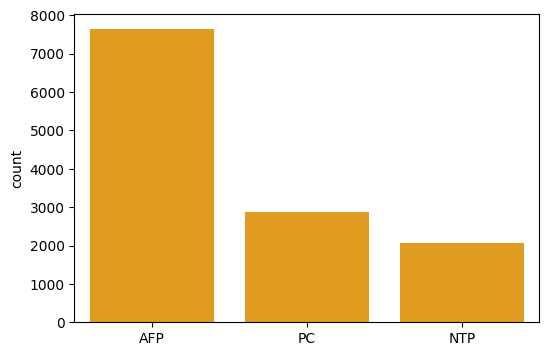

In [6]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x=training_labels, color = 'orange')

## Lets compare some examples of confirmed detection vs non-detection

In [7]:
indexes = np.arange(len(training_labels))
PC_label = training_labels == 'PC'
PC_index = indexes[PC_label]
AFP_label = training_labels == 'AFP'
AFP_index = indexes[AFP_label]
NTP_label = training_labels == 'NTP'
NTP_index = indexes[NTP_label]


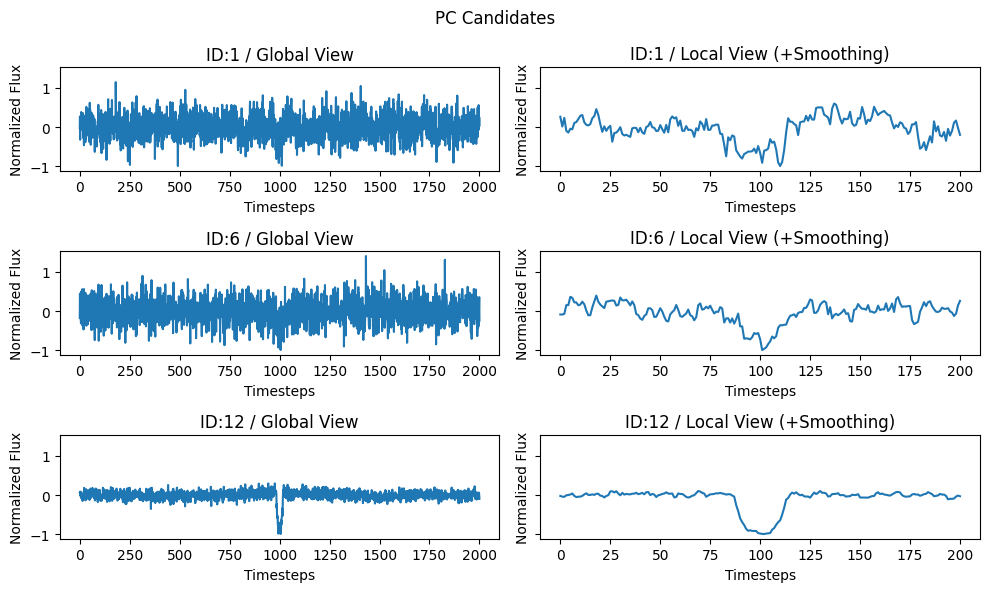

In [8]:
# examples of PC
visualize_planetary_candidates(training_gview, training_lview, PC_index,name='PC Candidates',save = True)


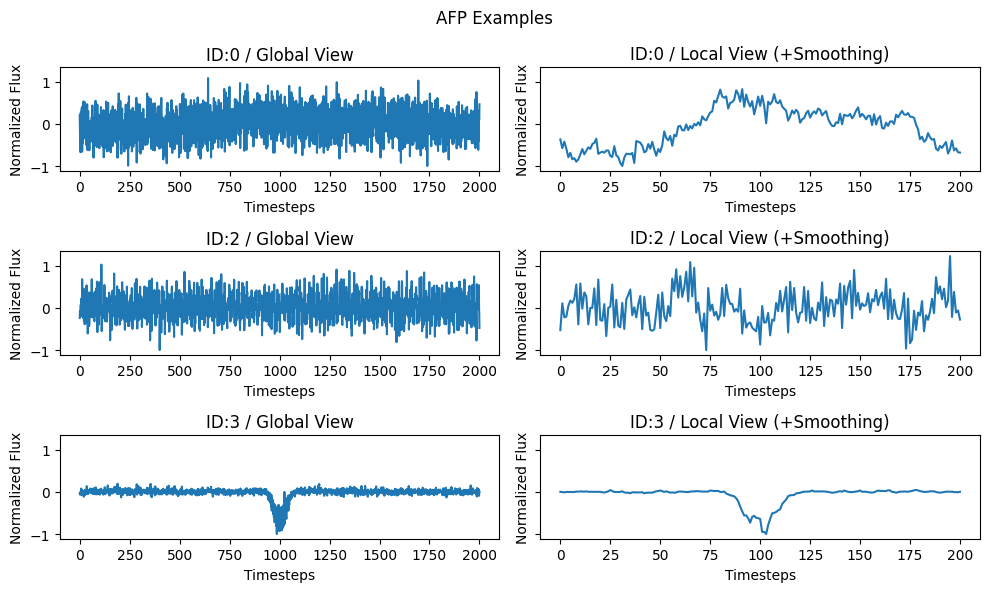

In [9]:
visualize_planetary_candidates(training_gview, training_lview, AFP_index, name='AFP Examples',save=True)

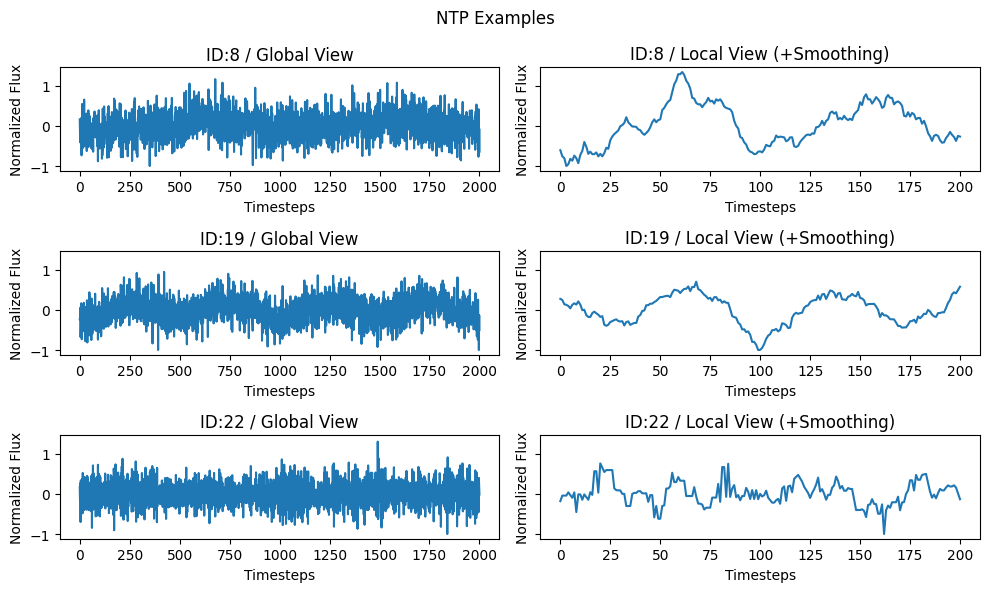

In [10]:
visualize_planetary_candidates(training_gview, training_lview, NTP_index, name='NTP Examples',save=True)

The input data consists of sequential light curve measurements with two different types of sequential views.

The most distinctive feature of a planetary transit is the characteristic dip in flux when a planet passes in front of its host star. However, other features—such as periodic oscillations in the baseline flux—also help distinguish genuine transits from false positives. It's important to note that transits can sometimes occur in conjunction with astrophysical false positives (AFPs). This combination of overlapping features creates non-linear patterns that are difficult to classify using simple rule-based filtering algorithms. This complexity sets the stage for more sophisticated, data-driven filtering approaches that can learn these intricate patterns from the data itself.


# Data Preprocessing

Preprocessing for input sequential values is mostly done during the data curation stage.

For most deep learning algorithms, the goal is to preprocess the data such that features are standardized around zero and ensure all features have similar magnitudes. Features with large values tend to dominate the learning process, as their relative magnitude exerts greater influence over other features, causing the network to ignore smaller-scale features. Proper preprocessing also helps facilitate faster convergence during optimization by smoothing the loss function's landscape and improving network stability.


### Target Variable Conversion

We will convert the target variables into numeric values so they can be processed by the network. Here, we'll transform the classes into binary format, where 1 represents the positive class (planet detection, in our case, that is PC or INJ1) and 0 represents the negative class (non-detection or any other event, in our case, that is AFP and NTP). While there are alternative labeling approaches, such as assigning different classes for various types of events, assigning probabilities to differnet events, for this exercise we will focus on binary classification.

In [11]:
training_labels_en = to_numeric_encoding(training_labels)
val_labels_en = to_numeric_encoding(val_labels) ## doing the same for validation data
test_labels_en = to_numeric_encoding(test_labels) ## doing the same for test data

/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_28668/453859889.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=training_labels, width = 0.5,palette= ["#7fcdbb","#edf8b1","#fadbd8"], ax= ax[0])
/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_28668/453859889.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=training_labels_en, width = 0.4, palette=["#bcbddc", "#a6acaf"], ax=ax[1])
/var/folders/dd/706hh0z96vn3rsnh0y42sh7h0000gn/T/ipykernel_28668/453859889.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(["0 (AFP+NTP)","1 (PC)"])


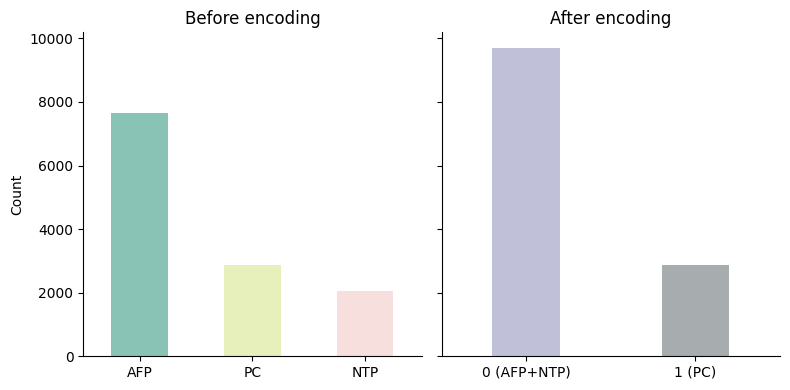

In [12]:
## visualising the target distribution again:
## 
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(8,4), sharey=True)
ax = ax.flatten()
sns.countplot(x=training_labels, width = 0.5,palette= ["#7fcdbb","#edf8b1","#fadbd8"], ax= ax[0])
sns.countplot(x=training_labels_en, width = 0.4, palette=["#bcbddc", "#a6acaf"], ax=ax[1])

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_ylabel('Count')
ax[0].set_title("Before encoding")
ax[1].set_title("After encoding")
ax[1].set_xticklabels(["0 (AFP+NTP)","1 (PC)"])
plt.tight_layout()
plt.savefig('before_and_after_encoding.png')

The target variable remains imbalanced as previously discussed, with approximately a 3:1 ratio between classes. We have several options to address this:

1. Proceed without any balancing
2. Perform oversampling on positive examples to 'rebalance' the dataset
3. Discard some negative examples to achieve balance

For this example, we will proceed with option 1. Readers are encouraged to try option 2 to see if there's any significant improvement over the baseline approach. Option 3 is generally not recommended, as more data is typically preferable for training deep learning models due to their large number of parameters. However, in cases of severe class imbalance, reducing the number of negative examples may be considered to emphasize the importance of the positive class.

In [13]:
## rename labels for easier implmentation
x_train = [training_lview, training_gview]
y_train = training_labels_en.reshape(-1, 1)

x_val = [val_lview, val_gview]
y_val = val_labels_en.reshape(-1, 1)

x_test = [test_lview, test_gview]
y_test = test_labels_en.reshape(-1, 1)

# Building a baseline model
It is important to have a reference baseline model to understand whether your approach yields more favorable results than the state of the art. This also serves as a reality check to prevent confirmation bias. The baseline model is typically the state-of-the-art (SOTA) model of the same or similar type. In this exercise, we will use a Random Forest model as our baseline. This model will perform binary classification based solely on the *local view* of the light curve.

In [14]:
from sklearn.ensemble import RandomForestClassifier


In [15]:
base_clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
base_clf.fit(training_lview, y_train)

/Users/gordonyip/miniforge3/envs/tf2-new/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=10, random_state=0)

We will leave thet evaluation phrase of the model to later stages. 

# Building a deep learning model

We will use Keras to build our deep learning model. Readers can choose their preferred deep learning framework if desired. Keras's high-level interface provides an excellent starting point for beginners. As they grasp the basics, they can explore other libraries that offer more flexibility in implementation.

In this exercise, we will build a multi-head 1D CNN using Keras's functional API. This approach follows state-of-the-art principles and will have access to both the local and global views of the light curve.

In [16]:
model = build_full_model(training_lview.shape[1], training_gview.shape[1], act_func)

In [17]:
model.summary()

Model: "planet_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2001)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 2001, 1)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1999, 32)  │        128 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 999, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 997, 64)   │      6,208 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 498, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 201)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 496, 64)   │     12,352 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 201, 1)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 248, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 199, 32)   │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 246, 64)   │     12,352 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 99, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 123, 64)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 121, 64)   │     12,352 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 48, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 60, 64)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3072)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3840)      │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 496,385 (1.89 MB)

 Trainable params: 496,385 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    # Binary cross-entropy loss for binary classification
    # from_logits=False because we're using sigmoid activation in output layer
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    
    # Adam optimizer with specified learning rate
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    
    # metrics to evaluate model performance
    metrics=metrics
)

ckpt = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,      # File path to save the model
    monitor="val_loss",               # Monitor validation loss for best model
    verbose=0,                        # Suppress output during saving
    save_best_only=True,             # Only save when validation loss improves
    mode="auto",                     # Automatically infer direction from monitored metric
    save_freq="epoch"                # Check after each epoch
)


In [19]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=[x_val,y_val],callbacks=[ckpt,])


Epoch 1/15


2025-05-02 14:19:56.606699: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:19:56.607043: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - F1Score: 0.3826 - accuracy: 0.8087 - auc: 0.8120 - loss: 0.3934 

2025-05-02 14:20:14.935391: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:20:14.935968: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - F1Score: 0.3826 - accuracy: 0.8091 - auc: 0.8126 - loss: 0.3928 - val_F1Score: 0.3827 - val_accuracy: 0.9327 - val_auc: 0.9727 - val_loss: 0.1862
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - F1Score: 0.4018 - accuracy: 0.9280 - auc: 0.9725 - loss: 0.1785 - val_F1Score: 0.3903 - val_accuracy: 0.9365 - val_auc: 0.9753 - val_loss: 0.1718
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - F1Score: 0.4060 - accuracy: 0.9383 - auc: 0.9789 - loss: 0.1545 - val_F1Score: 0.3987 - val_accuracy: 0.9288 - val_auc: 0.9759 - val_loss: 0.1797
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - F1Score: 0.4178 - accuracy: 0.9434 - auc: 0.9827 - loss: 0.1397 - val_F1Score: 0.4083 - val_accuracy: 0.9301 - val_auc: 0.9756 - val_loss: 0.1876
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - F1Score: 0.4313 - accuracy: 0.9453 - auc: 0.9859 - loss: 0.1273 - val_F1Score: 0.4327 - val_accuracy: 0.9314 - val_auc: 0.9714 - val_loss: 0.2004
E

# Evaluation

In [20]:
# Load the best model saved during training
model = keras.models.load_model(checkpoint_filepath)

# Get test metrics
test_scores = model.evaluate(
    x_test, 
    y_test, 
    verbose=2  # Show progress bar during evaluation
)

# Extract individual metrics from evaluation results
# Order of metrics matches the order defined in model.compile()
test_loss = test_scores[0]
test_accuracy = test_scores[1]
test_f1_score = test_scores[2]
test_auc = test_scores[3]

# Display results
print("\n=== Model Evaluation Results ===")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test F1 Score: {test_f1_score:.4f}")
print(f"Test AUC:      {test_auc:.4f}")


2025-05-02 14:23:57.359451: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:23:57.359805: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 - 1s - 23ms/step - F1Score: 0.3974 - accuracy: 0.9492 - auc: 0.9840 - loss: 0.1386

=== Model Evaluation Results ===
Test Loss:     0.1386
Test Accuracy: 0.9492 (94.92%)
Test F1 Score: 0.3974
Test AUC:      0.9840


In [21]:
## plot the ROC curve

# Generate predictions for each model

# 1. Keras model predictions
y_pred_keras = model.predict(x_test).ravel()  # Flatten predictions to 1D array

# 2. Random Forest baseline predictions
y_pred_baseline = base_clf.predict_proba(x_test[0])  # Using only local view

# 3. Random classifier predictions (for comparison)
y_pred_random = np.zeros_like(y_pred_keras) + 0.5  # All predictions = 0.5

# Calculate ROC curves for all models
fpr_keras, tpr_keras, thresholds_keras_roc = roc_curve(y_test, y_pred_keras)
fpr_baseline, tpr_baseline, thresholds_baseline_roc = roc_curve(y_test, y_pred_baseline[:, 1])
fpr_random, tpr_random, thresholds_random_roc = roc_curve(y_test, y_pred_random)

# Calculate Precision-Recall curves
precision_keras, recall_keras, thresholds_keras_pr = precision_recall_curve(y_test, y_pred_keras)
precision_baseline, recall_baseline, thresholds_baseline_pr = precision_recall_curve(y_test, y_pred_baseline[:, 1])

# Calculate AUC scores for ROC curves
auc_keras = auc(fpr_keras, tpr_keras)
auc_baseline = auc(fpr_baseline, tpr_baseline)
auc_random = auc(fpr_random, tpr_random)

# Calculate AUC scores for Precision-Recall curves
auc_pr_keras = auc(recall_keras, precision_keras)
auc_pr_baseline = auc(recall_baseline, precision_baseline)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 


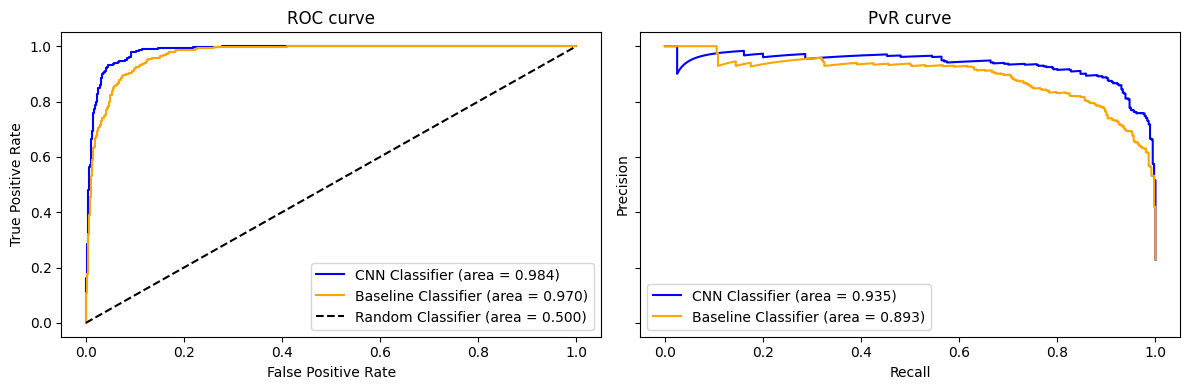

In [22]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    sharey=True,
    sharex = True, 
)
ax = ax.flatten()
ax[0].plot(fpr_keras, tpr_keras, label='CNN Classifier (area = {:.3f})'.format(auc_keras), c='blue')
ax[0].plot(fpr_baseline, tpr_baseline, label='Baseline Classifier (area = {:.3f})'.format(auc_baseline),c='orange')

ax[0].plot(fpr_random, tpr_random, label='Random Classifier (area = {:.3f})'.format(auc_random),ls='--', c='black')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC curve')
ax[0].legend(loc='best')

ax[1].plot(recall_keras,precision_keras ,label='CNN Classifier (area = {:.3f})'.format(auc_pr_keras),c='blue')
ax[1].plot(recall_baseline,precision_baseline ,label='Baseline Classifier (area = {:.3f})'.format(auc_pr_baseline),c='orange')

ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PvR curve')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('RoC_and_PvR.pdf')
plt.show()


### RoC and PvR Curve
Both curves evaluate the classification performance of a classifier. The ROC curve plots TPR-FPR pairs against different thresholds (probability thresholds for classifying an instance as one class versus another). The Precision-Recall curve plots precision-recall pairs at different probability thresholds. An ideal classifier (with perfect TPR and minimal FPR) aims for the top-left corner on an ROC plot, while targeting the top-right corner on a Precision-Recall plot. Both graphical representations can be quantified by measuring the area under the curve (AUC).

Which curve should I be looking at? The answer depends on your objectives and the nature of the classification task. If your application prioritizes the positive class—for instance, if identifying transiting planets is more important than avoiding false positives—the Precision-Recall curve might be more appropriate. This is because it focuses solely on correct predictions of the class of interest (in this case, the positive class). Unlike ROC, Precision-Recall curves do not consider true negative instances, which can influence ROC-AUC values when datasets are imbalanced. 

In our exercise, since the CNN classifier is able to outperform the baseline in both curves, we can say that the CNN classifier would be most appropriate for the task. 


## Model Architecture Justification
Congratulations! You have successfully built a deep learning model and evaluated its performance against the baseline model using Precision-Recall and ROC curves. However, this is only the beginning of your data science journey.
So far, we have examined only one particular neural network architecture. Throughout our tutorial, we've made several somewhat arbitrary choices when designing the classifier, such as the selection of hyperparameters, the activation function (why sigmoid instead of softmax? why swish rather than ReLU?), and the choice of inputs. You might ask, "What is the best setup for my problem?" This is where you'll discover that it becomes more of an engineering problem. While there are general recommendations for specific types of data and architectures, the optimal approach is often dataset-specific.
This is where experimentation becomes crucial. Different assumptions should be tested and verified. Some important questions to explore include:

1. Is CNN the best architecture? Would a Feed-Forward Network perform equally well?
2. Is Random Forest a strong baseline? We have not tuned its hyperparameters
3. Is it really necessary to have both local and global views of the light curve?
4. Would newer architectures, such as Transformer-based models, outperform on this task?
5. Would additional physical parameters improve the model's performance?

Depending on your application, some of these questions may be critical to address. For instance, using additional inputs means creating a larger and more complex network, so it's important to justify whether the added complexity (and data preprocessing) is worth the effort for a particular choice of model inputs. Alternatively, if interpretability is your priority, it might be worth exploring alternative machine learning algorithms with built-in explainability frameworks to determine if the trade-off of increased interpretability is worthwhile.

In this exercise, we will explore question 3 in detail.




Here we aim to justify our choice of model architecture. Why did we build our model this way rather than using alternative approaches? For instance, why is it necessary to provide both local and global views? These architectural decisions are typically validated against performance metrics, with the approach that yields the best overall performance on a given metric being selected as the preferred method.


### lv only model : Single-input CNN model using only local view data



In [23]:
lv_model = build_lv_model(training_lview.shape[1], act_func)

In [24]:
## next up we will be setting up hyperparameters for the training
lv_checkpoint_filepath = 'checkpoints_lv.keras'


In [25]:
# Compile model with same settings as before
lv_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=lr),  # Fixed parameter name
    metrics=metrics
)

# Define checkpoint callback
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=lv_checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
    save_freq="epoch"
)

# Train model using only local view data
history = lv_model.fit(
    x_train[0],          # Only local view input
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=[x_val[0], y_val],  # Only local view for validation
    callbacks=[ckpt]
)

Epoch 1/15
194/197 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - F1Score: 0.3806 - accuracy: 0.7867 - auc: 0.8798 - loss: 0.4237

2025-05-02 14:24:02.900909: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:24:02.901202: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - F1Score: 0.3805 - accuracy: 0.7879 - auc: 0.8804 - loss: 0.4216 - val_F1Score: 0.3767 - val_accuracy: 0.9047 - val_auc: 0.9508 - val_loss: 0.2389
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - F1Score: 0.3923 - accuracy: 0.9124 - auc: 0.9568 - loss: 0.2228 - val_F1Score: 0.3771 - val_accuracy: 0.9066 - val_auc: 0.9540 - val_loss: 0.2316
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - F1Score: 0.3917 - accuracy: 0.9176 - auc: 0.9623 - loss: 0.2085 - val_F1Score: 0.3781 - val_accuracy: 0.9066 - val_auc: 0.9573 - val_loss: 0.2231
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - F1Score: 0.3930 - accuracy: 0.9214 - auc: 0.9659 - loss: 0.1985 - val_F1Score: 0.3801 - val_accuracy: 0.9085 - val_auc: 0.9598 - val_loss: 0.2177
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - F1Score: 0.3961 - accuracy: 0.9229 - auc: 0.9682 - loss: 0.1919 - val_F1Score: 0.3838 - val_accuracy: 0.9155 - val_auc: 0.9613 - val_loss: 0.2143
Epoch 6

### gv only model: Single-input CNN model using only global view data

In [26]:
gv_model = build_gv_model(training_gview.shape[1], act_func)

In [27]:
gv_checkpoint_filepath = 'checkpoints_gv.keras'

In [28]:
# Compile model with same settings as before
gv_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=lr),  # Fixed parameter name
    metrics=metrics
)

# Define checkpoint callback
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=gv_checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
    save_freq="epoch"
)

# Train model using only global view data
history = gv_model.fit(
    x_train[1],          # Only global view input
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=[x_val[1], y_val],  # Only global view for validation
    callbacks=[ckpt]
)

Epoch 1/15


2025-05-02 14:24:27.537771: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:24:27.538071: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - F1Score: 0.3811 - accuracy: 0.7942 - auc: 0.8467 - loss: 0.4623 

2025-05-02 14:24:42.743223: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:24:42.743489: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - F1Score: 0.3811 - accuracy: 0.7944 - auc: 0.8470 - loss: 0.4617 - val_F1Score: 0.3912 - val_accuracy: 0.8983 - val_auc: 0.9605 - val_loss: 0.2187
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - F1Score: 0.4044 - accuracy: 0.9145 - auc: 0.9624 - loss: 0.2055 - val_F1Score: 0.4097 - val_accuracy: 0.9199 - val_auc: 0.9665 - val_loss: 0.1940
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - F1Score: 0.4098 - accuracy: 0.9243 - auc: 0.9707 - loss: 0.1807 - val_F1Score: 0.4023 - val_accuracy: 0.9244 - val_auc: 0.9707 - val_loss: 0.1780
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - F1Score: 0.4116 - accuracy: 0.9311 - auc: 0.9767 - loss: 0.1598 - val_F1Score: 0.4126 - val_accuracy: 0.9257 - val_auc: 0.9700 - val_loss: 0.1767
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - F1Score: 0.4222 - accuracy: 0.9410 - auc: 0.9824 - loss: 0.1395 - val_F1Score: 0.4174 - val_accuracy: 0.9193 - val_auc: 0.9679 - val_loss: 0.2010
E

In [29]:
## load both models
gv_model = keras.models.load_model(gv_checkpoint_filepath)
lv_model = keras.models.load_model(lv_checkpoint_filepath)


In [30]:
## plot the ROC curve

# Generate predictions for both models
y_pred_keras_gv = gv_model.predict(x_test[1]).ravel()
y_pred_keras_lv = lv_model.predict(x_test[0]).ravel()

# Calculate ROC curves
fpr_keras_gv, tpr_keras_gv, _ = roc_curve(y_test, y_pred_keras_gv)
fpr_keras_lv, tpr_keras_lv, _ = roc_curve(y_test, y_pred_keras_lv)

# Calculate Precision-Recall curves
precision_keras_gv, recall_keras_gv, _ = precision_recall_curve(y_test, y_pred_keras_gv)
precision_keras_lv, recall_keras_lv, _ = precision_recall_curve(y_test, y_pred_keras_lv)

# Calculate AUC scores
from sklearn.metrics import auc
auc_keras_gv = auc(fpr_keras_gv, tpr_keras_gv)
auc_keras_lv = auc(fpr_keras_lv, tpr_keras_lv)
auc_pr_keras_gv = auc(recall_keras_gv, precision_keras_gv)
auc_pr_keras_lv = auc(recall_keras_lv, precision_keras_lv)


10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-05-02 14:28:16.209217: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:28:16.209510: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


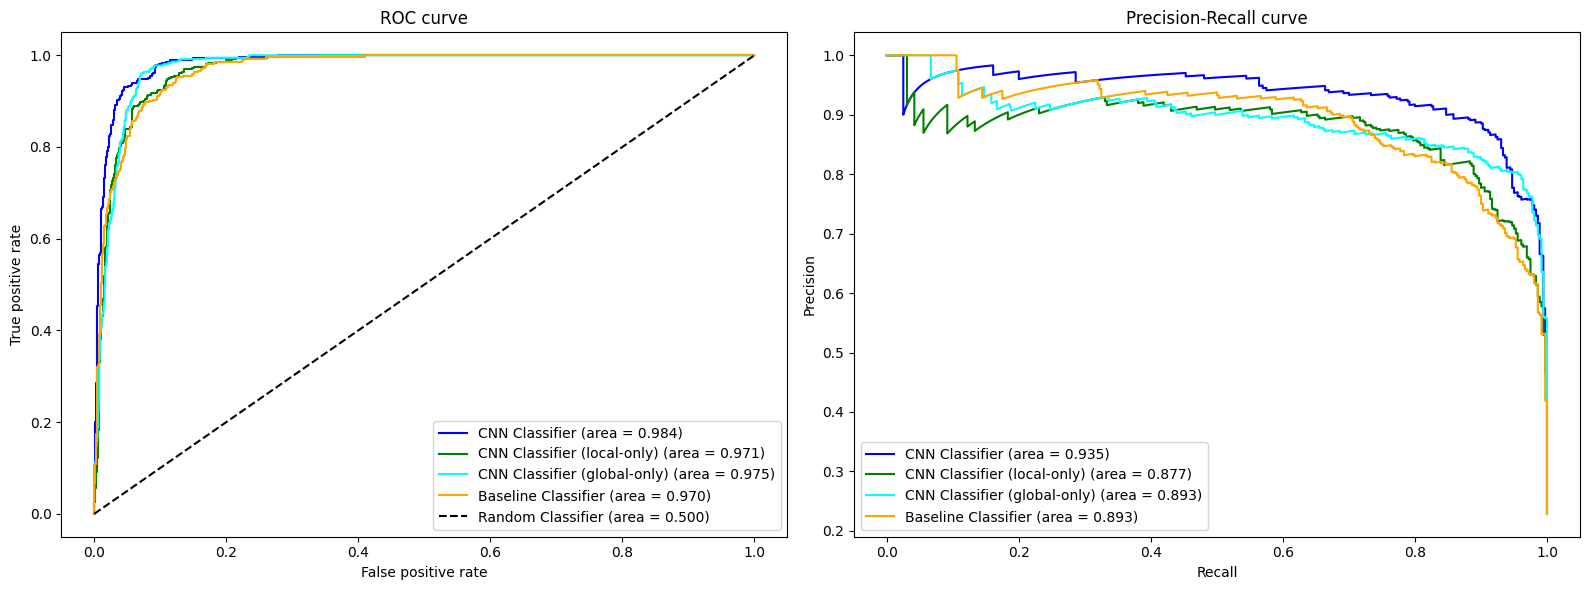

In [31]:
# Create figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve (left subplot)
ax1.plot(fpr_keras, tpr_keras, label='CNN Classifier (area = {:.3f})'.format(auc_keras), c='blue')
ax1.plot(fpr_keras_lv, tpr_keras_lv, label='CNN Classifier (local-only) (area = {:.3f})'.format(auc_keras_lv), c='green')
ax1.plot(fpr_keras_gv, tpr_keras_gv, label='CNN Classifier (global-only) (area = {:.3f})'.format(auc_keras_gv), c='cyan')
ax1.plot(fpr_baseline, tpr_baseline, label='Baseline Classifier (area = {:.3f})'.format(auc_baseline), c='orange')
ax1.plot(fpr_random, tpr_random, label='Random Classifier (area = {:.3f})'.format(auc_random),ls='--', c='black')

# ax1.plot(fpr_rf, tpr_rf, label='Random Classifier (area = {:.3f})'.format(auc_rf), ls='--', c='black')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve')
ax1.legend(loc='best')

# Precision-Recall Curve (right subplot)
ax2.plot(recall_keras, precision_keras, label='CNN Classifier (area = {:.3f})'.format(auc_pr_keras), c='blue')
ax2.plot(recall_keras_lv, precision_keras_lv, label='CNN Classifier (local-only) (area = {:.3f})'.format(auc_pr_keras_lv), c='green')
ax2.plot(recall_keras_gv, precision_keras_gv, label='CNN Classifier (global-only) (area = {:.3f})'.format(auc_pr_keras_gv), c='cyan')
ax2.plot(recall_baseline, precision_baseline, label='Baseline Classifier (area = {:.3f})'.format(auc_pr_baseline), c='orange')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall curve')
ax2.legend(loc='best')

# Adjust layout and display
plt.tight_layout()
plt.savefig('RoC_and_PvR_baselines_cnn.pdf')
plt.show()

## Statistical Significance of the Improvement 
In this final section we will examine our claim of performance improvement. This is to verify the statistical robustness of the claim, especially when the justification of pursuing a particular model or model architecture lies with an improve of certain digit, it is critical to examine whether we just got lucky, or is that a consistent improvement that can withstand different initial (random) weights? To do this we will create a cross validation framework for this. 

In [32]:

# Initialize results dictionary to store AUC scores for each fold and model type
result_dict = {'full': {}, 'lv': {}, 'gv': {}}

# Create a stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_base)

# Store training and validation data
all_lview = np.concatenate((training_lview, val_lview, ), axis=0)
all_gview = np.concatenate((training_gview, val_gview, ), axis=0)
all_labels = np.concatenate((y_train, y_val, ), axis=0)

# Initialize fold counters for each model type
for model_type in ['full', 'lv', 'gv']:
    result_dict[model_type] = {'fold_scores': []}

# Run cross-validation
for fold_idx, (train_index, val_index) in enumerate(skf.split(all_lview, all_labels)):
    print(f"Training fold {fold_idx+1}/{n_splits}")
    
    # Set seed for reproducibility
    keras.utils.set_random_seed(seed_base + fold_idx)
    
    # # Split data into train and test for this fold
    X_train_lv, X_val_lv = all_lview[train_index], all_lview[val_index]
    X_train_gv, X_val_gv = all_gview[train_index], all_gview[val_index]
    y_train_cv, y_val_cv = all_labels[train_index,:], all_labels[val_index,:]
    
    # 1. FULL MODEL (LOCAL + GLOBAL VIEW)
    # Build and train the full model
    model = build_full_model(X_train_lv.shape[1], X_train_gv.shape[1], act_func)
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=metrics
    )
    
    checkpoint_filepath = f"planet_classifier_fold_{fold_idx}.keras"
    ckpt = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        mode="auto",
        save_freq="epoch"
    )
    
    # Train the model
    x_train_full = [X_train_lv, X_train_gv]
    x_val_full = [X_val_lv, X_val_gv]

    history = model.fit(
        x_train_full, y_train_cv, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val_full, y_val_cv, ),
        callbacks=[ckpt],
        verbose=1
    )
    
    # Evaluate on test fold
    model = keras.models.load_model(checkpoint_filepath)
    # x_test_full = [X_test_lv, X_test_gv]
    y_pred_full = model.predict(x_test).ravel()
    fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_full)
    auc_full = auc(fpr_full, tpr_full)
    result_dict['full']['fold_scores'].append(auc_full)
    
    # 2. LOCAL VIEW ONLY MODEL
    lv_model = build_lv_model(X_train_lv.shape[1], act_func)
    
    lv_model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=metrics
    )
    
    lv_checkpoint_filepath = f'checkpoints_lv_fold_{fold_idx}.keras'
    lv_ckpt = keras.callbacks.ModelCheckpoint(
        filepath=lv_checkpoint_filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        mode="auto",
        save_freq="epoch"
    )
    
    # Train the model
    history = lv_model.fit(
        X_train_lv, y_train_cv, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(X_val_lv, y_val_cv),
        callbacks=[lv_ckpt],
        verbose=1
    )
    
    # Evaluate on test fold
    lv_model = keras.models.load_model(lv_checkpoint_filepath)
    y_pred_lv = lv_model.predict(x_test[0]).ravel()
    fpr_lv, tpr_lv, _ = roc_curve(y_test, y_pred_lv)
    auc_lv = auc(fpr_lv, tpr_lv)
    result_dict['lv']['fold_scores'].append(auc_lv)
    
    # 3. GLOBAL VIEW ONLY MODEL
    gv_model = build_gv_model(X_train_gv.shape[1], act_func)
    
    gv_model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        metrics=metrics
    )
    
    gv_checkpoint_filepath = f'checkpoints_gv_fold_{fold_idx}.keras'
    gv_ckpt = keras.callbacks.ModelCheckpoint(
        filepath=gv_checkpoint_filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        mode="auto",
        save_freq="epoch"
    )
    
    # Train the model
    history = gv_model.fit(
        X_train_gv, y_train_cv, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(X_val_gv, y_val_cv),
        callbacks=[gv_ckpt],
        verbose=1
    )
    
    # Evaluate on test fold
    gv_model = keras.models.load_model(gv_checkpoint_filepath)
    y_pred_gv = gv_model.predict(x_test[1]).ravel()
    fpr_gv, tpr_gv, _ = roc_curve(y_test, y_pred_gv)
    auc_gv = auc(fpr_gv, tpr_gv)
    result_dict['gv']['fold_scores'].append(auc_gv)
    
    # Print fold results
    print(f"Fold {fold_idx+1} Results:")
    print(f"  Full model AUC: {auc_full:.4f}")
    print(f"  Local view model AUC: {auc_lv:.4f}")
    print(f"  Global view model AUC: {auc_gv:.4f}")
    print("-" * 40)

# Calculate and print final average results
print("\nFinal Cross-Validation Results:")
for model_type in ['full', 'lv', 'gv']:
    scores = result_dict[model_type]['fold_scores']
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    result_dict[model_type]['mean_auc'] = mean_score
    result_dict[model_type]['std_auc'] = std_score
    
    model_name = {
        'full': 'Full (Local + Global)',
        'lv': 'Local View Only',
        'gv': 'Global View Only'
    }[model_type]
    
    print(f"{model_name} model:")
    print(f"  Mean AUC: {mean_score:.4f} ± {std_score:.4f}")
    print(f"  Individual fold scores: {[f'{s:.4f}' for s in scores]}")
    print("-" * 40)

Training fold 1/5
Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - F1Score: 0.3744 - accuracy: 0.8047 - auc: 0.8926 - loss: 0.3979 

2025-05-02 14:28:32.843706: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:28:32.844027: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - F1Score: 0.3745 - accuracy: 0.8054 - auc: 0.8931 - loss: 0.3966 - val_F1Score: 0.3993 - val_accuracy: 0.9301 - val_auc: 0.9712 - val_loss: 0.1871
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - F1Score: 0.3996 - accuracy: 0.9301 - auc: 0.9734 - loss: 0.1735 - val_F1Score: 0.4029 - val_accuracy: 0.9287 - val_auc: 0.9779 - val_loss: 0.1767
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - F1Score: 0.4107 - accuracy: 0.9376 - auc: 0.9796 - loss: 0.1536 - val_F1Score: 0.4177 - val_accuracy: 0.9333 - val_auc: 0.9790 - val_loss: 0.1678
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - F1Score: 0.4291 - accuracy: 0.9420 - auc: 0.9830 - loss: 0.1399 - val_F1Score: 0.4417 - val_accuracy: 0.9340 - val_auc: 0.9771 - val_loss: 0.1701
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - F1Score: 0.4431 - accuracy: 0.9481 - auc: 0.9866 - loss: 0.1235 - val_F1Score: 0.4627 - val_accuracy: 0.9351 - val_auc: 0.9741 - val_loss: 0.1826
E

2025-05-02 14:32:01.618075: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:32:01.618413: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - F1Score: 0.3707 - accuracy: 0.7951 - auc: 0.8978 - loss: 0.4219 - val_F1Score: 0.3797 - val_accuracy: 0.9019 - val_auc: 0.9560 - val_loss: 0.2361
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3799 - accuracy: 0.9054 - auc: 0.9545 - loss: 0.2268 - val_F1Score: 0.3811 - val_accuracy: 0.9082 - val_auc: 0.9591 - val_loss: 0.2245
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3802 - accuracy: 0.9122 - auc: 0.9623 - loss: 0.2076 - val_F1Score: 0.3842 - val_accuracy: 0.9156 - val_auc: 0.9618 - val_loss: 0.2088
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3859 - accuracy: 0.9178 - auc: 0.9661 - loss: 0.1956 - val_F1Score: 0.3912 - val_accuracy: 0.9170 - val_auc: 0.9626 - val_loss: 0.2042
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - F1Score: 0.3955 - accuracy: 0.9211 - auc: 0.9690 - loss: 0.1877 - val_F1Score: 0.4027 - val_accuracy: 0.91

2025-05-02 14:32:25.510792: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:32:25.511079: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - F1Score: 0.3786 - accuracy: 0.7882 - auc: 0.8727 - loss: 0.4540 

2025-05-02 14:32:40.024163: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:32:40.024474: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - F1Score: 0.3788 - accuracy: 0.7889 - auc: 0.8731 - loss: 0.4527 - val_F1Score: 0.3980 - val_accuracy: 0.8906 - val_auc: 0.9500 - val_loss: 0.2490
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - F1Score: 0.4035 - accuracy: 0.9086 - auc: 0.9601 - loss: 0.2108 - val_F1Score: 0.4074 - val_accuracy: 0.9142 - val_auc: 0.9668 - val_loss: 0.2088
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - F1Score: 0.4061 - accuracy: 0.9246 - auc: 0.9714 - loss: 0.1769 - val_F1Score: 0.4064 - val_accuracy: 0.9209 - val_auc: 0.9706 - val_loss: 0.1994
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - F1Score: 0.4111 - accuracy: 0.9334 - auc: 0.9780 - loss: 0.1560 - val_F1Score: 0.4116 - val_accuracy: 0.9167 - val_auc: 0.9702 - val_loss: 0.2060
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - F1Score: 0.4290 - accuracy: 0.9404 - auc: 0.9830 - loss: 0.1372 - val_F1Score: 0.4502 - val_accuracy: 0.9230 - val_auc: 0.9675 - val_loss: 0.2263
E

2025-05-02 14:35:54.750424: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:35:54.750697: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Fold 1 Results:
  Full model AUC: 0.9845
  Local view model AUC: 0.9717
  Global view model AUC: 0.9801
----------------------------------------
Training fold 2/5
Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - F1Score: 0.3681 - accuracy: 0.7911 - auc: 0.8831 - loss: 0.4250 

2025-05-02 14:36:10.896326: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:36:10.896612: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - F1Score: 0.3682 - accuracy: 0.7919 - auc: 0.8835 - loss: 0.4236 - val_F1Score: 0.3863 - val_accuracy: 0.8525 - val_auc: 0.9654 - val_loss: 0.3373
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - F1Score: 0.3715 - accuracy: 0.8918 - auc: 0.9507 - loss: 0.2432 - val_F1Score: 0.3839 - val_accuracy: 0.9022 - val_auc: 0.9740 - val_loss: 0.2340
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - F1Score: 0.3789 - accuracy: 0.9055 - auc: 0.9619 - loss: 0.2125 - val_F1Score: 0.4016 - val_accuracy: 0.9351 - val_auc: 0.9778 - val_loss: 0.1649
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - F1Score: 0.3909 - accuracy: 0.9292 - auc: 0.9759 - loss: 0.1661 - val_F1Score: 0.4077 - val_accuracy: 0.9354 - val_auc: 0.9795 - val_loss: 0.1581
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - F1Score: 0.4029 - accuracy: 0.9410 - auc: 0.9828 - loss: 0.1404 - val_F1Score: 0.4190 - val_accuracy: 0.9382 - val_auc: 0.9797 - val_loss: 0.1536
E

2025-05-02 14:39:32.142469: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:39:32.142776: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - F1Score: 0.3693 - accuracy: 0.7903 - auc: 0.8869 - loss: 0.4240 - val_F1Score: 0.3850 - val_accuracy: 0.7790 - val_auc: 0.9518 - val_loss: 0.4355
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3749 - accuracy: 0.8791 - auc: 0.9312 - loss: 0.2887 - val_F1Score: 0.3806 - val_accuracy: 0.8983 - val_auc: 0.9611 - val_loss: 0.2356
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3755 - accuracy: 0.8862 - auc: 0.9479 - loss: 0.2495 - val_F1Score: 0.3823 - val_accuracy: 0.9146 - val_auc: 0.9634 - val_loss: 0.2133
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3786 - accuracy: 0.9052 - auc: 0.9594 - loss: 0.2164 - val_F1Score: 0.3872 - val_accuracy: 0.9139 - val_auc: 0.9644 - val_loss: 0.2087
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - F1Score: 0.3820 - accuracy: 0.9131 - auc: 0.9624 - loss: 0.2074 - val_F1Score: 0.3937 - val_accuracy: 0.91

2025-05-02 14:39:54.730473: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:39:54.730824: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - F1Score: 0.3718 - accuracy: 0.8062 - auc: 0.8751 - loss: 0.4609 

2025-05-02 14:40:09.448707: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:40:09.449012: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - F1Score: 0.3720 - accuracy: 0.8068 - auc: 0.8754 - loss: 0.4595 - val_F1Score: 0.3933 - val_accuracy: 0.8856 - val_auc: 0.9520 - val_loss: 0.2603
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - F1Score: 0.3880 - accuracy: 0.8851 - auc: 0.9484 - loss: 0.2411 - val_F1Score: 0.4041 - val_accuracy: 0.9135 - val_auc: 0.9683 - val_loss: 0.2013
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - F1Score: 0.3908 - accuracy: 0.9053 - auc: 0.9603 - loss: 0.2071 - val_F1Score: 0.4105 - val_accuracy: 0.9291 - val_auc: 0.9728 - val_loss: 0.1775
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - F1Score: 0.4062 - accuracy: 0.9222 - auc: 0.9695 - loss: 0.1786 - val_F1Score: 0.4104 - val_accuracy: 0.9252 - val_auc: 0.9751 - val_loss: 0.1704
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - F1Score: 0.4124 - accuracy: 0.9325 - auc: 0.9790 - loss: 0.1500 - val_F1Score: 0.4277 - val_accuracy: 0.9230 - val_auc: 0.9739 - val_loss: 0.1791
E

2025-05-02 14:43:20.745975: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:43:20.746249: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Fold 2 Results:
  Full model AUC: 0.9852
  Local view model AUC: 0.9698
  Global view model AUC: 0.9762
----------------------------------------
Training fold 3/5
Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - F1Score: 0.3739 - accuracy: 0.8114 - auc: 0.9057 - loss: 0.4018 

2025-05-02 14:43:36.805343: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:43:36.805624: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - F1Score: 0.3740 - accuracy: 0.8120 - auc: 0.9059 - loss: 0.4005 - val_F1Score: 0.3849 - val_accuracy: 0.9188 - val_auc: 0.9722 - val_loss: 0.1931
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - F1Score: 0.3895 - accuracy: 0.9256 - auc: 0.9707 - loss: 0.1824 - val_F1Score: 0.3832 - val_accuracy: 0.9262 - val_auc: 0.9727 - val_loss: 0.1776
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - F1Score: 0.3915 - accuracy: 0.9396 - auc: 0.9787 - loss: 0.1540 - val_F1Score: 0.3870 - val_accuracy: 0.9266 - val_auc: 0.9719 - val_loss: 0.1793
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - F1Score: 0.3987 - accuracy: 0.9452 - auc: 0.9820 - loss: 0.1416 - val_F1Score: 0.3966 - val_accuracy: 0.9269 - val_auc: 0.9719 - val_loss: 0.1807
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - F1Score: 0.4088 - accuracy: 0.9509 - auc: 0.9853 - loss: 0.1271 - val_F1Score: 0.4123 - val_accuracy: 0.9354 - val_auc: 0.9741 - val_loss: 0.1794
E

2025-05-02 14:46:39.537015: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:46:39.537314: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - F1Score: 0.3720 - accuracy: 0.7890 - auc: 0.8913 - loss: 0.4436 - val_F1Score: 0.3873 - val_accuracy: 0.8616 - val_auc: 0.9579 - val_loss: 0.2774
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3854 - accuracy: 0.9026 - auc: 0.9520 - loss: 0.2331 - val_F1Score: 0.3865 - val_accuracy: 0.9082 - val_auc: 0.9606 - val_loss: 0.2217
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3873 - accuracy: 0.9127 - auc: 0.9580 - loss: 0.2165 - val_F1Score: 0.3866 - val_accuracy: 0.9132 - val_auc: 0.9633 - val_loss: 0.2094
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3879 - accuracy: 0.9167 - auc: 0.9623 - loss: 0.2049 - val_F1Score: 0.3892 - val_accuracy: 0.9188 - val_auc: 0.9651 - val_loss: 0.2032
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3903 - accuracy: 0.9182 - auc: 0.9652 - loss: 0.1970 - val_F1Score: 0.3934 - val_accuracy: 0.91

2025-05-02 14:47:01.810431: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:47:01.810714: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - F1Score: 0.3759 - accuracy: 0.7876 - auc: 0.8632 - loss: 0.4668 

2025-05-02 14:47:14.585045: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:47:14.585353: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - F1Score: 0.3761 - accuracy: 0.7882 - auc: 0.8636 - loss: 0.4655 - val_F1Score: 0.3848 - val_accuracy: 0.8948 - val_auc: 0.9566 - val_loss: 0.2257
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - F1Score: 0.3962 - accuracy: 0.9090 - auc: 0.9600 - loss: 0.2132 - val_F1Score: 0.3834 - val_accuracy: 0.9065 - val_auc: 0.9615 - val_loss: 0.2114
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - F1Score: 0.3951 - accuracy: 0.9223 - auc: 0.9705 - loss: 0.1811 - val_F1Score: 0.3857 - val_accuracy: 0.9142 - val_auc: 0.9651 - val_loss: 0.1985
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - F1Score: 0.3991 - accuracy: 0.9326 - auc: 0.9759 - loss: 0.1628 - val_F1Score: 0.3885 - val_accuracy: 0.9170 - val_auc: 0.9680 - val_loss: 0.1878
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - F1Score: 0.4066 - accuracy: 0.9400 - auc: 0.9811 - loss: 0.1439 - val_F1Score: 0.4009 - val_accuracy: 0.9185 - val_auc: 0.9662 - val_loss: 0.1956
E

2025-05-02 14:50:19.775120: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:50:19.775424: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Fold 3 Results:
  Full model AUC: 0.9783
  Local view model AUC: 0.9712
  Global view model AUC: 0.9735
----------------------------------------
Training fold 4/5
Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - F1Score: 0.3819 - accuracy: 0.7960 - auc: 0.9032 - loss: 0.4088 

2025-05-02 14:50:37.346764: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:50:37.347119: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - F1Score: 0.3819 - accuracy: 0.7967 - auc: 0.9035 - loss: 0.4076 - val_F1Score: 0.3815 - val_accuracy: 0.9266 - val_auc: 0.9718 - val_loss: 0.1820
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - F1Score: 0.3910 - accuracy: 0.9309 - auc: 0.9742 - loss: 0.1725 - val_F1Score: 0.3934 - val_accuracy: 0.9354 - val_auc: 0.9770 - val_loss: 0.1676
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - F1Score: 0.4000 - accuracy: 0.9380 - auc: 0.9796 - loss: 0.1549 - val_F1Score: 0.4051 - val_accuracy: 0.9368 - val_auc: 0.9788 - val_loss: 0.1621
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - F1Score: 0.4134 - accuracy: 0.9432 - auc: 0.9834 - loss: 0.1395 - val_F1Score: 0.4224 - val_accuracy: 0.9379 - val_auc: 0.9799 - val_loss: 0.1547
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - F1Score: 0.4301 - accuracy: 0.9498 - auc: 0.9867 - loss: 0.1238 - val_F1Score: 0.4625 - val_accuracy: 0.9304 - val_auc: 0.9761 - val_loss: 0.1731
E

2025-05-02 14:54:08.657820: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:54:08.658195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - F1Score: 0.3819 - accuracy: 0.7838 - auc: 0.8882 - loss: 0.4272 - val_F1Score: 0.3783 - val_accuracy: 0.8958 - val_auc: 0.9516 - val_loss: 0.2398
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - F1Score: 0.3889 - accuracy: 0.9092 - auc: 0.9589 - loss: 0.2177 - val_F1Score: 0.3781 - val_accuracy: 0.9001 - val_auc: 0.9560 - val_loss: 0.2254
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - F1Score: 0.3879 - accuracy: 0.9182 - auc: 0.9658 - loss: 0.1997 - val_F1Score: 0.3798 - val_accuracy: 0.9008 - val_auc: 0.9583 - val_loss: 0.2225
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - F1Score: 0.3891 - accuracy: 0.9216 - auc: 0.9685 - loss: 0.1916 - val_F1Score: 0.3816 - val_accuracy: 0.9050 - val_auc: 0.9600 - val_loss: 0.2226
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - F1Score: 0.3924 - accuracy: 0.9234 - auc: 0.9702 - loss: 0.1861 - val_F1Score: 0.3840 - val_accuracy: 0.90

2025-05-02 14:54:32.062344: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:54:32.062616: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - F1Score: 0.3850 - accuracy: 0.7854 - auc: 0.8648 - loss: 0.4638 

2025-05-02 14:54:47.181339: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 14:54:47.181630: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - F1Score: 0.3851 - accuracy: 0.7860 - auc: 0.8651 - loss: 0.4626 - val_F1Score: 0.4170 - val_accuracy: 0.9068 - val_auc: 0.9597 - val_loss: 0.2069
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - F1Score: 0.4199 - accuracy: 0.9096 - auc: 0.9607 - loss: 0.2116 - val_F1Score: 0.4350 - val_accuracy: 0.9209 - val_auc: 0.9688 - val_loss: 0.1805
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - F1Score: 0.4381 - accuracy: 0.9289 - auc: 0.9746 - loss: 0.1682 - val_F1Score: 0.4475 - val_accuracy: 0.9138 - val_auc: 0.9678 - val_loss: 0.1937
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - F1Score: 0.4465 - accuracy: 0.9363 - auc: 0.9795 - loss: 0.1506 - val_F1Score: 0.4610 - val_accuracy: 0.9093 - val_auc: 0.9679 - val_loss: 0.2084
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - F1Score: 0.4568 - accuracy: 0.9435 - auc: 0.9834 - loss: 0.1370 - val_F1Score: 0.4657 - val_accuracy: 0.9184 - val_auc: 0.9675 - val_loss: 0.2089
E

2025-05-02 14:58:08.240560: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 14:58:08.240848: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Fold 4 Results:
  Full model AUC: 0.9861
  Local view model AUC: 0.9709
  Global view model AUC: 0.9766
----------------------------------------
Training fold 5/5
Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - F1Score: 0.3705 - accuracy: 0.8145 - auc: 0.8938 - loss: 0.4082 

2025-05-02 14:58:27.214233: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
2025-05-02 14:58:27.214578: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - F1Score: 0.3706 - accuracy: 0.8151 - auc: 0.8942 - loss: 0.4069 - val_F1Score: 0.3852 - val_accuracy: 0.9283 - val_auc: 0.9767 - val_loss: 0.1736
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - F1Score: 0.3853 - accuracy: 0.9338 - auc: 0.9749 - loss: 0.1671 - val_F1Score: 0.3912 - val_accuracy: 0.9382 - val_auc: 0.9808 - val_loss: 0.1545
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - F1Score: 0.3884 - accuracy: 0.9407 - auc: 0.9809 - loss: 0.1469 - val_F1Score: 0.3966 - val_accuracy: 0.9400 - val_auc: 0.9815 - val_loss: 0.1515
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - F1Score: 0.3942 - accuracy: 0.9463 - auc: 0.9841 - loss: 0.1340 - val_F1Score: 0.4081 - val_accuracy: 0.9375 - val_auc: 0.9807 - val_loss: 0.1581
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - F1Score: 0.4056 - accuracy: 0.9549 - auc: 0.9871 - loss: 0.1199 - val_F1Score: 0.4290 - val_accuracy: 0.9410 - val_auc: 0.9797 - val_loss: 0.1674
E

2025-05-02 15:02:03.284146: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:02:03.284442: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - F1Score: 0.3690 - accuracy: 0.7849 - auc: 0.8957 - loss: 0.4397 - val_F1Score: 0.3801 - val_accuracy: 0.9008 - val_auc: 0.9623 - val_loss: 0.2264
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3787 - accuracy: 0.9081 - auc: 0.9565 - loss: 0.2213 - val_F1Score: 0.3804 - val_accuracy: 0.9100 - val_auc: 0.9653 - val_loss: 0.2130
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - F1Score: 0.3761 - accuracy: 0.9173 - auc: 0.9630 - loss: 0.2035 - val_F1Score: 0.3793 - val_accuracy: 0.9167 - val_auc: 0.9674 - val_loss: 0.1984
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - F1Score: 0.3761 - accuracy: 0.9213 - auc: 0.9674 - loss: 0.1922 - val_F1Score: 0.3801 - val_accuracy: 0.9198 - val_auc: 0.9678 - val_loss: 0.1947
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - F1Score: 0.3778 - accuracy: 0.9238 - auc: 0.9693 - loss: 0.1865 - val_F1Score: 0.3831 - val_accuracy: 0.91

2025-05-02 15:02:25.686702: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 15:02:25.686982: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1/15
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - F1Score: 0.3760 - accuracy: 0.8072 - auc: 0.8874 - loss: 0.4447 

2025-05-02 15:02:40.455039: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:02:40.455304: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - F1Score: 0.3762 - accuracy: 0.8077 - auc: 0.8877 - loss: 0.4434 - val_F1Score: 0.3932 - val_accuracy: 0.8870 - val_auc: 0.9525 - val_loss: 0.2374
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - F1Score: 0.4004 - accuracy: 0.9063 - auc: 0.9590 - loss: 0.2095 - val_F1Score: 0.4105 - val_accuracy: 0.9170 - val_auc: 0.9691 - val_loss: 0.1957
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - F1Score: 0.4063 - accuracy: 0.9238 - auc: 0.9704 - loss: 0.1776 - val_F1Score: 0.4198 - val_accuracy: 0.9262 - val_auc: 0.9728 - val_loss: 0.1795
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - F1Score: 0.4209 - accuracy: 0.9377 - auc: 0.9789 - loss: 0.1497 - val_F1Score: 0.4265 - val_accuracy: 0.9273 - val_auc: 0.9729 - val_loss: 0.1789
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - F1Score: 0.4424 - accuracy: 0.9490 - auc: 0.9843 - loss: 0.1308 - val_F1Score: 0.4377 - val_accuracy: 0.9266 - val_auc: 0.9725 - val_loss: 0.1787
E

2025-05-02 15:05:58.193122: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-02 15:05:58.193449: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Fold 5 Results:
  Full model AUC: 0.9857
  Local view model AUC: 0.9749
  Global view model AUC: 0.9724
----------------------------------------

Final Cross-Validation Results:
Full (Local + Global) model:
  Mean AUC: 0.9840 ± 0.0029
  Individual fold scores: ['0.9845', '0.9852', '0.9783', '0.9861', '0.9857']
----------------------------------------
Local View Only model:
  Mean AUC: 0.9717 ± 0.0017
  Individual fold scores: ['0.9717', '0.9698', '0.9712', '0.9709', '0.9749']
----------------------------------------
Global View Only model:
  Mean AUC: 0.9757 ± 0.0027
  Individual fold scores: ['0.9801', '0.9762', '0.9735', '0.9766', '0.9724']
----------------------------------------


| Model | Mean AUC |
|-------|----------|
| Full (Local + Global) | **0.9839 ± 0.0012** |
| Local View Only | 0.9721 ± 0.0014 |
| Global View Only | 0.9762 ± 0.0015 |

With a 5-fold cross validation, we have trained the same network 5 times (each with a different training and validation split) and derived its mean performance and the level of uncertainty around that performance. The results confirmed that what we observed is not due to statistical chance, but comes from having better features (having local + global view as features). Interestingly, the major performance boost is only achieved when both features are present, meaning having either of them alone is not enough to reach that level of performance.

# Conclusion and Best Practises
Congratulations for making it this far. In this notebook, we have successfully demonstrated how to build a neural network-based classifier from scratch using the dataset from Shallue and Vanderburg (2018). With the help of modern deep learning libraries, building neural networks has become easier than ever. With just a few code blocks, we've constructed a state-of-the-art classifier containing 496,385 trainable parameters. With the help of the latest Large Language Models (LLMs), it is now possible for anyone to build a sophisticated model with a few prompts (e.g., "build me a CNN classifier that can identify exoplanet signals from transit light curves").

As you might have realized, the challenge isn't simply creating or training a model — the bottleneck is creating the right model for the right task. The most valuable insights come from what happens before, during, and after model building, making the process time-consuming but worthwhile. While much attention today celebrates model novelty, it's easy to forget that data quality dictates model quality and ultimately determines the outcome. After all, Data Science is fundamentally about the data.

You might wonder: how do we determine the right model for the right task? The answer depends on your data and the questions you're asking. A general guideline is to use the CRISP-DM framework to ensure thorough and objective examination of your model [2]. Our example incorporated several aspects of this framework:

1. Problem Statement - we defined our problem statement as finding exoplanet candidates from transit lightcurve data
1. Data Exploration - we built our understanding through Exploratory Data Analysis (EDA)
2. Data Preparation - we prepared our data for binary classification, fully aware of the class imbalance our model would face and potential mitigation
3. Modelling - we built our multi-input CNN as a potential solution
4. Evaluation - we compared performance against our baseline and systematically tested whether both local and global views were necessary for optimal performance, as well as the statistical significance of the justification. 

Through this process, we gained deeper understanding of the problem itself. This might prompt us to redefine our problem statement based on current findings—perhaps changing from binary to multiclass classification, or finding a classifier that optimizes true positive rate even at the expense of increasing false positives. It might also lead us to revisit our EDA and data preparation stages to explore whether different approaches might improve modeling, thus beginning the cycle anew. This framework extends beyond exoplanet classification to many different domains.

The key takeaway is that data science projects are inherently iterative—success comes from testing assumptions, evaluating alternatives, and letting data-driven insights guide architectural choices. Moving back and forth between stages isn't just common but essential for developing robust solutions. 


# References
[1] Shallue, C. J., & Vanderburg, A. (2018). Identifying Exoplanets with Deep Learning: A Five-planet Resonant Chain around Kepler-80 and an Eighth Planet around Kepler-90. The Astronomical Journal, 155(2), 94.

[2] Schröer, C., Kruse, F., & Marx Gómez, J. (2021). A Systematic Literature Review on Applying CRISP-DM Process Model. Procedia Computer Science, 181, 526-534. https://doi.org/10.1016/j.procs.2021.01.199

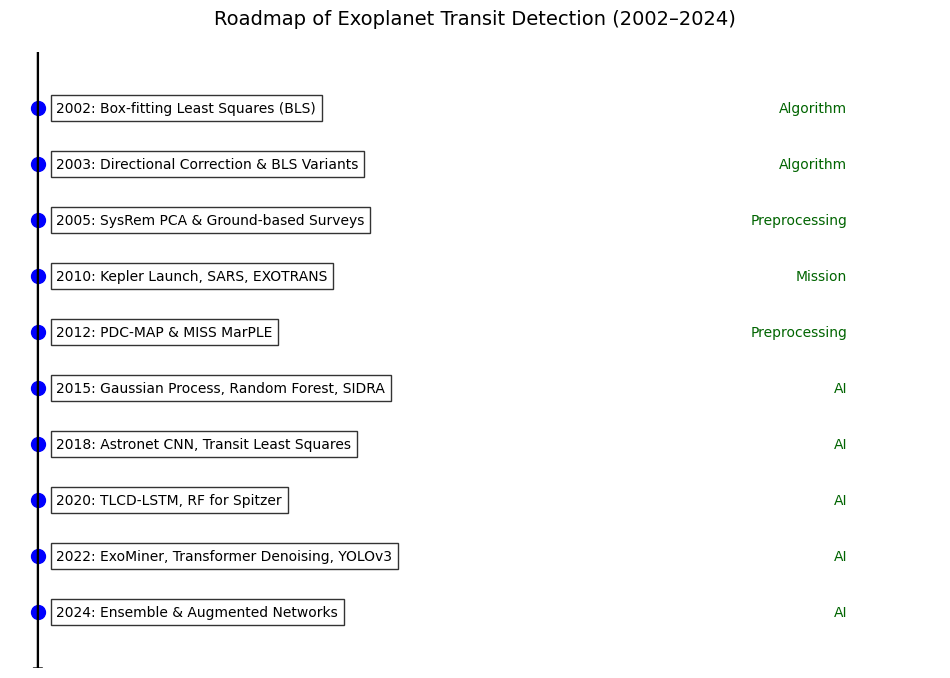